#### Packages required by PTI

In [ ]:
## Other packages are already builtin in the Colab interpreter
!pip install wandb
!pip install lpips

#### Ninja installation for StyleGAN

In [ ]:
## Used for faster inference of StyleGAN by enabling C++ code compilation

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

## Download Pretrained models

**Please note that sometimes Google Drive rate limit is reached due to too many users downloading the pretrained models by Colab. Check for a failure message or check if the file size is the correct one. If not, download the files manually and upload them to the pretrained_models folder. We are working on changing the host to better one**

---



In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'PTI'

In [ ]:
!git clone https://github.com/danielroich/PTI.git $CODE_DIR

In [ ]:
os.chdir(f'./{CODE_DIR}')

In [ ]:
import os
import sys
import pickle
import numpy as np
from PIL import Image
import torch
from configs import paths_config, hyperparameters, global_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from IPython.display import display
import matplotlib.pyplot as plt
from scripts.latent_editor_wrapper import LatentEditorWrapper

In [ ]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
os.makedirs(save_path, exist_ok=True)

In [ ]:
os.chdir(save_path)

In [ ]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [ ]:
## Download pretrained StyleGAN on FFHQ 1024x1024
!wget {get_download_model_command('125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M', 'ffhq.pkl')}

In [ ]:
## Download Dlib tool for alingment, used for preprocessing images before PTI
!wget {get_download_model_command('1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR', 'align.dat')}

In [ ]:
os.chdir('/content/PTI')

## Configuration Setup

In [ ]:
image_dir_name = 'image'

## If set to true download desired image from given url. If set to False, assumes you have uploaded personal image to
## 'image_original' dir
use_image_online = True
image_name = 'personal_image'
use_multi_id_training = False
global_config.device = 'cuda'
paths_config.e4e = '/content/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.input_data_id = image_dir_name
paths_config.input_data_path = f'/content/PTI/{image_dir_name}_processed'
paths_config.stylegan2_ada_ffhq = '/content/PTI/pretrained_models/ffhq.pkl'
paths_config.checkpoints_dir = '/content/PTI/'
paths_config.style_clip_pretrained_mappers = '/content/PTI/pretrained_models'
hyperparameters.use_locality_regularization = False

## Preproccess Data

In [ ]:
os.makedirs(f'./{image_dir_name}_original', exist_ok=True)
os.makedirs(f'./{image_dir_name}_processed', exist_ok=True)
os.chdir(f'./{image_dir_name}_original')

In [ ]:
## Download real face image
## If you want to use your own image skip this part and upload an image/images of your choosing to image_original dir
if use_image_online:
  !wget -O personal_image.jpg https://static01.nyt.com/images/2019/09/09/opinion/09Hunter1/09Hunter1-superJumbo.jpg ## Photo of Sarena Wiliams

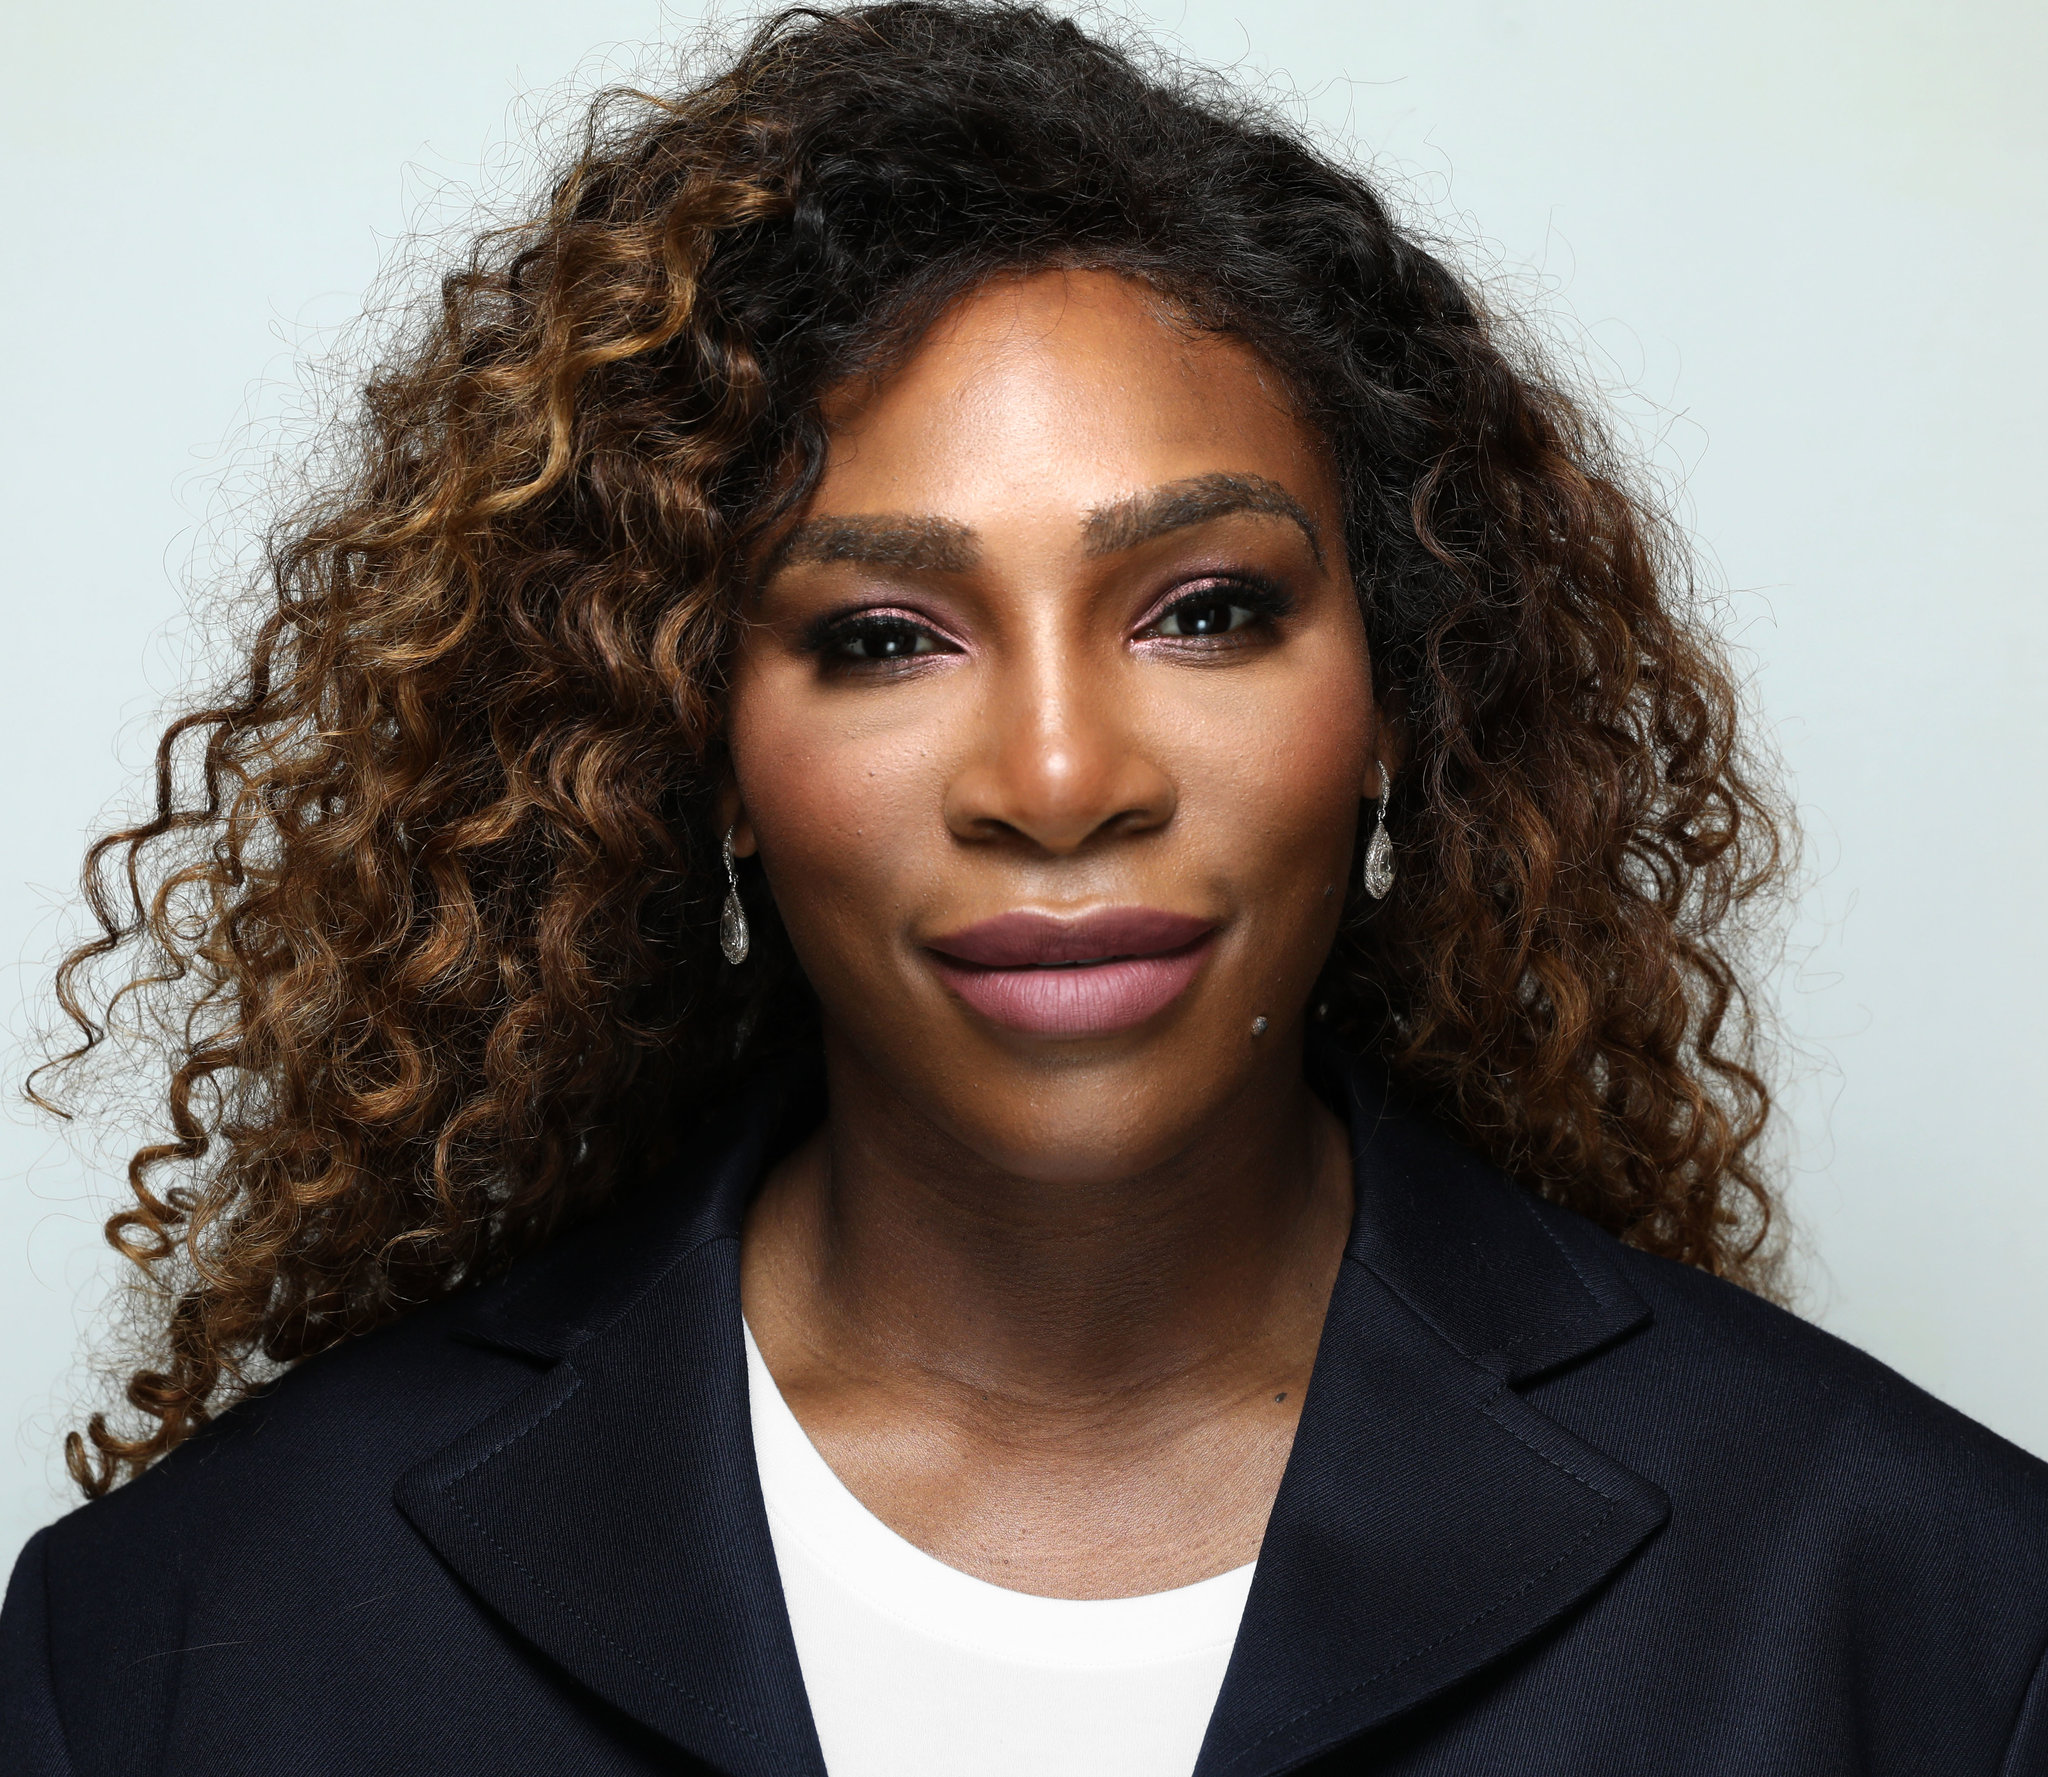

In [ ]:
original_image = Image.open(f'{image_name}.jpg')
original_image

In [ ]:
os.chdir('/content/PTI')

In [ ]:
pre_process_images(f'/content/PTI/{image_dir_name}_original')

100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


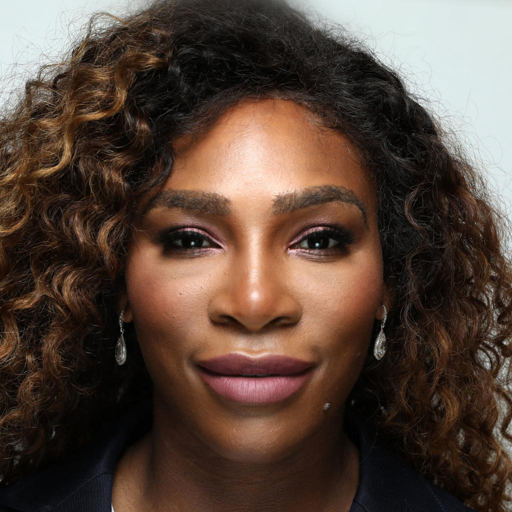

In [ ]:
aligned_image = Image.open(f'/content/PTI/{image_dir_name}_processed/{image_name}.jpeg')
aligned_image.resize((512,512))

## PTI Inversion

In order to run PTI and use StyleGAN2-ada, the cwd should the parent of 'torch_utils' and 'dnnlib'.

In case use_multi_id_training is set to True and many images are inverted simultaneously
activating the regularization to keep the *W* Space intact is recommended.

If indeed the regularization is activated then please increase the number of pti steps from 350 to 450 at least
using hyperparameters.max_pti_steps

In [ ]:
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

## Visualize results

In [ ]:
def display_alongside_source_image(images): 
    res = np.concatenate([np.array(image) for image in images], axis=1) 
    return Image.fromarray(res) 

In [ ]:
def load_generators(model_id, image_name):
  with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    old_G = pickle.load(f)['G_ema'].cuda()
    
  with open(f'{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt', 'rb') as f_new: 
    new_G = torch.load(f_new).cuda()

  return old_G, new_G

In [ ]:
generator_type = paths_config.multi_id_model_type if use_multi_id_training else image_name
old_G, new_G = load_generators(model_id, generator_type)

In [ ]:
def plot_syn_images(syn_images): 
  for img in syn_images: 
      img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()[0] 
      plt.axis('off') 
      resized_image = Image.fromarray(img,mode='RGB').resize((256,256)) 
      display(resized_image) 
      del img 
      del resized_image 
      torch.cuda.empty_cache()

If multi_id_training was used for several images.
You can alter the w_pivot index which is currently configured to 0, and then running
the visualization code again. Using the same generator on different latent codes.

In [ ]:
w_path_dir = f'{paths_config.embedding_base_dir}/{paths_config.input_data_id}'
embedding_dir = f'{w_path_dir}/{paths_config.pti_results_keyword}/{image_name}'
w_pivot = torch.load(f'{embedding_dir}/0.pt')

In [ ]:
old_image = old_G.synthesis(w_pivot, noise_mode='const', force_fp32 = True)
new_image = new_G.synthesis(w_pivot, noise_mode='const', force_fp32 = True)

In [ ]:
print('Upper image is the inversion before Pivotal Tuning and the lower image is the product of pivotal tuning')
plot_syn_images([old_image, new_image])

## InterfaceGAN edits

In [ ]:
latent_editor = LatentEditorWrapper()
latents_after_edit = latent_editor.get_single_interface_gan_edits(w_pivot, [-2, 2])

In order to get different edits. Such as younger face or make the face smile more. Please change the factors passed to "get_single_interface_gan_edits".
Currently the factors are [-2,2]. You can pass for example: range(-3,3)

In [ ]:
for direction, factor_and_edit in latents_after_edit.items():
  print(f'Showing {direction} change')
  for latent in factor_and_edit.values():
    old_image = old_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    new_image = new_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    plot_syn_images([old_image, new_image])

## StyleCLIP editing

### Download pretrained models

In [ ]:
os.chdir('/content/PTI/pretrained_models')

In [ ]:
# More pretrained mappers can be found at: "https://github.com/orpatashnik/StyleCLIP/blob/main/utils.py"
# Download Afro mapper
!wget {get_download_model_command('1i5vAqo4z0I-Yon3FNft_YZOq7ClWayQJ', 'afro.pt')}

In [ ]:
# Download Mohawk mapper
!wget {get_download_model_command('1oMMPc8iQZ7dhyWavZ7VNWLwzf9aX4C09', 'mohawk.pt')}

In [ ]:
!wget {get_download_model_command('1cUv_reLE6k3604or78EranS7XzuVMWeO', 'e4e_ffhq_encode.pt')}

In [ ]:
os.chdir('/content/PTI')

### Use PTI with e4e backbone for StyleCLIP

In [ ]:
hyperparameters.first_inv_type = 'w+'
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

### Apply edit

In [ ]:
from scripts.pti_styleclip import styleclip_edit

In [ ]:
paths_config.checkpoints_dir = '/content/PTI'
os.chdir('/content/PTI')
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types = ['afro'], use_wandb=False)
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types = ['mohawk'], use_wandb=False)

In [ ]:
original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_afro.jpg'
new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_afro.jpg'
original_styleCLIP = Image.open(original_styleCLIP_path).resize((256,256))
new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256,256))

In [ ]:
display_alongside_source_image([original_styleCLIP, new_styleCLIP])

In [ ]:
original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_mohawk.jpg'
new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_mohawk.jpg'
original_styleCLIP = Image.open(original_styleCLIP_path).resize((256,256))
new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256,256))

In [ ]:
display_alongside_source_image([original_styleCLIP, new_styleCLIP])

## Other methods comparison

### Invert image using other methods

In [ ]:
from scripts.latent_creators import e4e_latent_creator
from scripts.latent_creators import sg2_latent_creator
from scripts.latent_creators import sg2_plus_latent_creator

In [ ]:
e4e_latent_creator = e4e_latent_creator.E4ELatentCreator()
e4e_latent_creator.create_latents()
sg2_latent_creator = sg2_latent_creator.SG2LatentCreator(projection_steps = 600)
sg2_latent_creator.create_latents()
sg2_plus_latent_creator = sg2_plus_latent_creator.SG2PlusLatentCreator(projection_steps = 1200)
sg2_plus_latent_creator.create_latents()

In [ ]:
inversions = {}
sg2_embedding_dir = f'{w_path_dir}/{paths_config.sg2_results_keyword}/{image_name}'
inversions[paths_config.sg2_results_keyword] = torch.load(f'{sg2_embedding_dir}/0.pt')
e4e_embedding_dir = f'{w_path_dir}/{paths_config.e4e_results_keyword}/{image_name}'
inversions[paths_config.e4e_results_keyword] = torch.load(f'{e4e_embedding_dir}/0.pt')
sg2_plus_embedding_dir = f'{w_path_dir}/{paths_config.sg2_plus_results_keyword}/{image_name}'
inversions[paths_config.sg2_plus_results_keyword] = torch.load(f'{sg2_plus_embedding_dir}/0.pt')

In [ ]:
def get_image_from_w(w, G):
  if len(w.size()) <= 2:
      w = w.unsqueeze(0) 
  img = G.synthesis(w, noise_mode='const', force_fp32=True) 
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy() 
  return img[0] 

In [ ]:
def plot_image_from_w(w, G): 
  img = get_image_from_w(w, G) 
  plt.axis('off') 
  resized_image = Image.fromarray(img,mode='RGB').resize((256,256)) 
  display(resized_image) 

In [ ]:
for inv_type, latent in inversions.items():
  print(f'Displaying {inv_type} inversion')
  plot_image_from_w(latent, old_G)
print(f'Displaying PTI inversion')
plot_image_from_w(w_pivot, new_G)